## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [4]:
df = pd.read_csv("ab_data.csv")

b. Use the below cell to find the number of rows in the dataset.

In [5]:
df.info()

# answer: 294478

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [6]:
df.nunique()

# answer: 290584

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [7]:
df["converted"].mean()

# answer: 0.1197

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [8]:
old_group = df[df["landing_page"]=="old_page"].groupby(["group"])["landing_page"].count()
new_group = df[df["landing_page"]=="new_page"].groupby(["group"])["landing_page"].count()
print(old_group["treatment"] + new_group["control"])

# answer: 3893

3893


f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

# answer: no

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
# removing entries in treatment group that received old page. 
indexNames = df[(df["group"]=="treatment") & (df["landing_page"]=="old_page")].index
df.drop(indexNames, inplace=True)

# removing entries in control group that received new page. 
indexNames = df[(df["group"]=="control") & (df["landing_page"]=="new_page")].index
df.drop(indexNames, inplace=True)

df2 = df

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.nunique()

# answer: 290584

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2["user_id"].duplicated()]

# answer: the user_id is 773192	

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? <br>

The non-unique id has new page while landing, and it's in the treatment group, it's not converted. 

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop_duplicates("user_id")

In [15]:
df2[df2["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
p_null = df2["converted"].mean()
print(p_null)

# answer: 0.1196

0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2[df2["group"]=="control"]["converted"].mean()

# answer: 0.1204

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2[df2["group"]=="treatment"]["converted"].mean()

# answer: 0.1188

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
n_new = df2[df2["landing_page"] == "new_page"]["landing_page"].count()
n_old = df2[df2["landing_page"] == "old_page"]["landing_page"].count()
print(n_new/(n_new + n_old))

# answer: 0.50

0.5000619442226688


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

In [20]:
from datetime import datetime
fmt = '%Y-%m-%d %H:%M:%S.%f'

end_new = df2[df2["group"] == "treatment"]["timestamp"].max() 
start_new = df2[df2["group"] == "treatment"]["timestamp"].min() 
end_old = df2[df2["group"] == "control"]["timestamp"].max() 
start_old = df2[df2["group"] == "control"]["timestamp"].min() 

ends_new = datetime.strptime(end_new, fmt)
starts_new = datetime.strptime(start_new, fmt)
duration_new = ends_new - starts_new
print(duration_new)
end_new, start_new, end_old, start_old

21 days, 23:59:38.718592


('2017-01-24 13:41:44.097174',
 '2017-01-02 13:42:05.378582',
 '2017-01-24 13:41:54.460509',
 '2017-01-02 13:42:15.234051')

***Answer***<br>
Half of the users were presented with new landing page, with the conversion rate for control and treatment groups at 12.04% and 11.88% respectively, which are close to each other. Right now, there isn't enough evidence to conclude whether the new or old page is better due to the following reasons: 
1. The conversion rates were based on data generated over 22 days from 2017-01-02 to 2017-01-24, it's difficult to conclude the trend will be sustaining. 
2. The sample size is 290584, depending on the population that the website is addressing, it's possible that bigger sample size is needed, or to simulate sampling distribution of the population and find the parameters. 


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer** <br>
Null **$H_{0}$**: the old page has higher than or same convertion rates as the new page. **$p_{old}$** >= **$p_{new}$**   <br>
Alternative **$H_{1}$**: the old page has lower converstion rate than the new page.  **$p_{old}$** < **$p_{new}$**   <br> 
Type I error rate: 5%.

$$H_0: p_{old} - p_{new} >= 0$$


$$H_1: p_{old} - p_{new} < 0$$


$$ \alpha = 0.05$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

$$H_0: p_{old} = p_{new} = 0.1196 $$

$$n_{new} = 145310 $$

$$n_{old} = 145274 $$

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
p_null

# answer: 0.1196

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_null

# answer: 0.1196

0.11959708724499628

c. What is $n_{new}$?

In [23]:
n_new = df2.query('landing_page=="new_page"')["user_id"].count()
n_new

# answer: 145311

145310

d. What is $n_{old}$?

In [24]:
n_old = df2[df2["landing_page"]=="old_page"]["user_id"].count()
n_old

# answer: 145274

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
df_treatment = df2.query('group == "treatment"')["converted"]
new_page_converted = df_treatment.sample(n_new, replace=True)
print(new_page_converted.mean())

# answer: 0.1185

0.11789278095107013


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
df_control = df2.query('group == "control"')["converted"]
old_page_converted = df_control.sample(n_old, replace=True)
print(old_page_converted.mean())

# answer: 0.1209

0.12156339055853077


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_page_converted.mean() - old_page_converted.mean()

# answer: -0.0024

-0.0036706096074606426

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

<font color='red'>revised code:</font>

In [28]:
new_page_converted = np.random.binomial(n_new, p_null, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_null, 10000)/n_old
p_diffs = new_page_converted - old_page_converted 

In [29]:
print(new_page_converted)
print(p_diffs)

[0.11946184 0.11999862 0.11939302 ... 0.11861537 0.1205767  0.12010873]
[ 4.81417014e-06 -3.25728970e-04  1.11996538e-03 ... -1.20647985e-03
  3.28064477e-04  2.45577912e-04]


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

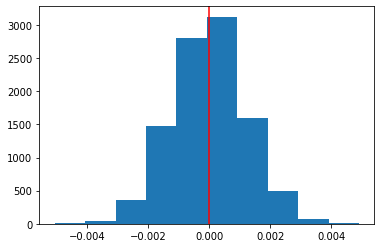

In [30]:
plt.hist(p_diffs);
plt.axvline(x=0, color="r");

From the sampling distribution created from bootstrapping, most of the treatment samples have lower converstion rate than control group. 

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
# actual difference observed in ab_data.csv
ab_data_new = df2[df2["landing_page"] == "new_page"]["converted"].mean()
ab_data_old = df2[df2["landing_page"] == "old_page"]["converted"].mean()
obs_diff = ab_data_new - ab_data_old
print(obs_diff)

-0.0015782389853555567


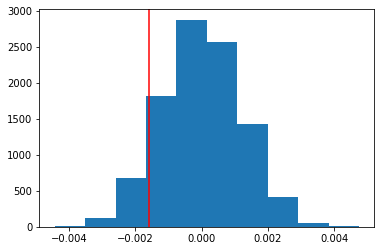

In [32]:
# since the null hypothesis indicates p_new = n_old, the center of the below histogram is located at 0.
null_vals = np.random.normal(0, np.std(p_diffs), 10000)
plt.hist(null_vals);
plt.axvline(x=obs_diff, color="r");

In [33]:
(null_vals > obs_diff).mean()

0.906

<font color='red'>revised code:</font>

In [34]:
(p_diffs > obs_diff).mean()

0.9063

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer** <br> <font color='red'>revised:</font>
The p value for the sample distribution is 0.90, which is a large probability that the sample mean falls in the difference of sampling distribution means. This suggests the chance of null hypothesis being true is high. <br>


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

<font color='red'>revised code:</font>

In [35]:
import statsmodels.api as sm

# number of conversions, not the probability
convert_old = len(df2.query("group == 'control' &  converted == 1"))
convert_new = len(df2.query("group == 'treatment' &  converted == 1"))
n_old = n_old
n_new = n_new
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

<font color='red'>revised code:</font>

In [36]:
from statsmodels.stats.proportion import proportions_ztest

count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])
stat, pval = proportions_ztest(count, nobs, alternative="smaller")

print(stat, pval)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer** <br><font color='red'>revised:</font>
The p value is the same as the result calculate in part j, confirming that there are 90% chance that an observation is true under the null hypothesis. This means that I failed to reject to null. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer**<br>  <font color='red'>revised:</font>
Since the goal of the model is to predict a probability of 0 (not converted) or 1 (converted), logistic regression model will be used. 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

<font color='red'>revised code:</font>

In [37]:
df2['ab_page'] = pd.get_dummies(df2["group"], drop_first=True)
df2.head()

/Users/lin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


In [38]:
df2.isnull().sum()
df2.dropna()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0
...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,0


In [39]:
df2["intercept"] = 1

/Users/lin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [40]:
logit_mod = sm.Logit(df2["converted"], df2[["intercept", "ab_page"]])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 10 Aug 2020   Pseudo R-squ.:               8.077e-06
Time:                        21:10:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [41]:
np.exp(-0.0150), 1/np.exp(-0.0150)

(0.9851119396030626, 1.015113064615719)

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

**Answer**<br><font color='red'>revised:</font>
Firstly, the p values of intercept and ab_page are 0 and 0.19 respectively, since they are small values (smaller than 0.50), both variables can be considered statitscally significant for the model. <br>

Secondly, the pseudo rsquared value is 8.077e-06, which indicates the model doesn't fit the statistics very well.

Lastly, the coefficient for ab_page is -0.0150, which means when receiving a new page, we expect a 0.99 times more likely to be converted, holding other variables constant. Or, if a user receives an old page, the chance of converting is 1.02 times higher than that of a new page. 

$$𝑓(x_1) = -1.9888 + -0.015x_1$$
$$𝑝(x_1) = \frac{1}{1 + exp(−𝑓(x_1))}$$

In [45]:
# model diagnostics and plotting - will the page/country interaction complicate it?
y = df2["converted"].values.reshape(-1,1)
X = df2[["ab_page"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [46]:
log_mod = LogisticRegression()
log_mod.fit(X_train, y_train.squeeze())
y_preds = log_mod.predict(X_test)
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(accuracy_score(y_test, y_preds))
confusion_matrix(y_test, y_preds)

0.0
0.8814662885774853


array([[64035,     0],
       [ 8611,     0]])

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer**<br><font color='red'>revised:</font>
The p-value differs from the value I found in part II because part III is two sided (two-tailed) test and Part II is a one sided test (one-tailed). 

#### Deriving p-values of one-tailed from two-tailed tests:
1. Decide whether the alternative hypothesis is left-tailed or right-tailed. If it's right-tailed, then subtract the p-value from one. In the sampling distribution above, it's right-tailed, thus we get 1-0.90, which is 0.1. 
2. Multiple the p-value from one-tailed test by 2 to obtain the p-value of two-tailed test. 

In the regression model, the p-value for ab_page is 0.190, while the p-value from the sampling distribution is 0.90, following the above proces, (1-0.9) x 2 = 0.2, which is close to 0.19. 

Interpreting the Type I error (p-value) from one-tailed test to two-tailed tests:
Since the alpha from sampling distribution approach is 0.05, the p-value for the variables from regresional models should be <= 0.1. 

In the regression model, the null hypothesis is that the explanatory variable ab_page is not significant for converted rate, the alternative hypothesis is that ab_page matters to conversion rate, a low p-value here suggests the alternative hypothesis, that ab_page is important for conversion. 

$$H_0: \beta_0 = 0$$
$$H_1: \beta_1 \neq 0$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer**<Br>
It's a good idea to consider other factors in the regressional model because in reality an outcome is usually a result of a combination of factors. To make the model more closer to reality, it's useful to take unknown variables into account. <br>
A potential disadvantage is that there might be linearity among the explonatory variables, which will impair the model. So I will check this using seaborn in the next step. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [47]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [48]:
### Create the necessary dummy variables
dummy = pd.get_dummies(df_new["country"])
df_new = pd.concat([df_new, dummy], axis = 1)
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


<font color='red'>revised code:</font>

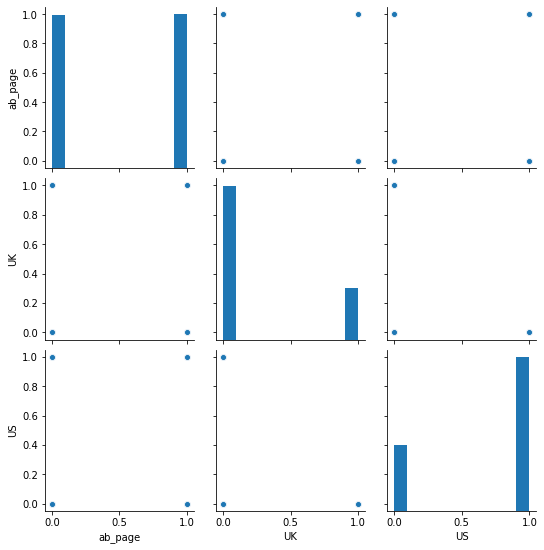

In [49]:
# check linearity among explanatory variables
sn.pairplot(df_new[["ab_page", "UK", "US"]]);

From the above pair plots, there's no linearity among the landing page and countries, thus I will use ab_page and two of the three countries in the multiple linear regression model. 

In [50]:
### Fit Your Linear Model And Obtain the Results
logit_mod = sm.Logit(df_new["converted"], df_new[["intercept", "ab_page", "UK", "US"]])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 10 Aug 2020   Pseudo R-squ.:               2.323e-05
Time:                        21:12:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [51]:
1/np.exp(-0.0149), np.exp(0.0506), np.exp(0.0408)

(1.0150115583846535, 1.0519020483004984, 1.0416437559600236)

**Answer**<br>
<font color='red'>revised:</font> In the statsmodels I chose Canada as the baseline variable/category to be compared against UK and US. All four variables have low p-values (0, 0.191, 0.074 and 0.13 for intercept, ab_page, UK and US respectively), which suggests they are statistically related to predicting the conversion, but since the Type I error rate should be less than 0.05, the p-values here should be less than 0.1, this means that the model should probably exclude ab_page and US. 

The model once again has a low pseudo R-squared, at 2.323e-05, which means the model explains very little proportion of the variability of the response data around its mean. 

From the coefficients, we can conclude that:
1. If a user receives the old page, the chance of conversion is 1.02 higher than otherwise, holding all other variables constant. 
2. A user from the UK is 1.05 more likely to be converted compared to in Canada, given that the page is the same. 
3. A user from the US is 1.04 more likely to be converted compared to in Canada, given that the page is the same. 

The equation can be computed as follows:
 
$$𝑓(x_1, x_2, x_3) = -2.0300 - 0.0149x_1 + 0.0506x_2 + 0.0408x_3 $$
$$𝑝(x_1, x_2) = \frac{1}{1 + exp(−𝑓(x_1, x_2, x_3)}$$

I run a model diagnostics and the accuracy score is 0.88, the confusion matrix shows that the model predicts everything as 0, which means in 88% of the cases the actual value is 0. 

<font color='red'>revised code:</font>

In [52]:
# model diagnostics and plotting - will the page/country interaction complicate it?
y = df_new["converted"].values.reshape(-1,1)
X = df_new[["ab_page", "UK", "US"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [54]:
log_mod = LogisticRegression()
log_mod.fit(X_train, y_train.squeeze())
y_preds = log_mod.predict(X_test)
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(accuracy_score(y_test, y_preds))
confusion_matrix(y_test, y_preds)

0.0
0.0
0.8810120309445806


/Users/lin/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[64002,     0],
       [ 8644,     0]])

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

**Answer**<br>
<font color='red'>revised:</font>
In this model, the r-squared is 3.482e-05. <br>

The p-values suggest that US, UK variables are by themselves not statistically relevant as they have large p values. However, the ab_page, interaction_uk and interaction_us variables are more relevant. However, since the Type I error rate should be less than 0.05, the p-values here should be less than 0.1, all variables' p-values exceed this threshold, thus this model is not ideal for the intended prediction.  <br> 

The coefficient of ab_page variable suggests that:
1. A user presented with old page is 1.07 times more likely to be converted, holding all other variables constant. 
2. The impact of country on conversion rate is dependent on which page they have received. 


The equation can be presented as:
$$𝑓(x_1, x_2, x_3) = -2.004 + 0.0175x_1 + 0.0118x_2 - 0.0674x_3 + 0.0469x_1x_3 + 0.0783x_2x_3 $$
$$𝑝(x_1, x_2, x_3) = \frac{1}{1 + exp(−𝑓(x_1, x_2, x_3))}$$


In [55]:
# df_new["interaction_ca"] = df_new["ab_page"]*df_new["CA"]
df_new["interaction_uk"] = df_new["ab_page"]*df_new["UK"]
df_new["interaction_us"] = df_new["ab_page"]*df_new["US"]
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US,interaction_ca,interaction_uk,interaction_us
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0


In [56]:
logit_mod= sm.Logit(df_new["converted"], df_new[["intercept", "US", "UK", "ab_page", "interaction_uk", "interaction_us"]])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 10 Aug 2020   Pseudo R-squ.:               3.482e-05
Time:                        21:12:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -2.0040      0.036    -55.008      0.000      -2.075      -1.933
US                 0.0175      0.038      0.465      0.642      -0.056       0.091
UK                 0.0118      0.040      0.296      0.767      -0.066       0.090
ab_page           -0.0674      0.052     -1.297      0.195      -0.169       0.034
interaction_uk     0.0783      0.057      1.378      0.168      -0.033       0.190
interaction_us     0.0469      0.054      0.872      0.383      -0.059       0.152
==================================================================================
"""

In [57]:
1/np.exp(-0.0674), np.exp(0.0783), np.exp(0.0469)

(1.0697232819209153, 1.0814470441230692, 1.048017202119183)

In [58]:
# model diagnostics and plotting - will the page/country interaction complicate it?
y = df_new["converted"].values.reshape(-1,1)
X = df_new[["ab_page", "UK", "US", "interaction_uk", "interaction_us"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [59]:
log_mod = LogisticRegression()
log_mod.fit(X_train, y_train.squeeze())
y_preds = log_mod.predict(X_test)
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(accuracy_score(y_test, y_preds))
confusion_matrix(y_test, y_preds)

0.0
0.0
0.8812460424524406


/Users/lin/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[64019,     0],
       [ 8627,     0]])

### Summary 
<font color='red'>revised:</font>In summary, we failed to reject the null hypothesis. Based on the current data, old page performs better in converting users. However, considering all models are non-conclusive, and the data was collected in a short duration of time, it's advisable that the website run the test longer in order to collect more data, which can hofully help us finding a better model. 


#### P-values
1. In the sampling distribution model, the p-value at 0.9 suggests that the type I error rate of the model can be as high as 0.1, exceeding that of alpha, thus this model is not ideal. 
2. In the first logistic regression model, ab_page's p-value at 0.19 is too high for desired alpha 0.10, thus it's also not ideal for prediction. 
3. In the second logistic regression models, all variables' p-values are higher then the type I error limit, so it's not ideal either. 

#### Rsquare values and confusion matrix
The rsquare of all three regression models are very low. The three models also similarly diagnosed as ineffective, as all the predictions from the models are 0. 



<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.